# imdb-embeddings dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: imdb-embeddings
- Model: transformer's pretrained DistilBertModel + LogisticRegression
- Metric: Classification accuracy

In [2]:
dataset_name = "imdb-embeddings" 
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch
metric_name = "accuracy"
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

# feature extraction is performed when the following code is executed. (cpu takes 10-ish mins)
exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    device=device,
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.7319999933242798


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    # KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    # DataShapley(cache_name=f"cached"), # Data-Shapley ## slow
    # BetaShapley(cache_name=f"cached"), # Beta-Shapley ## slow
    # DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000201


100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


Elapsed time LeaveOneOut(): 0:06:45.400911


100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:04:49.222466


100%|██████████| 2000/2000 [00:49<00:00, 40.21it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:50.821479


100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Elapsed time AME(num_models=1000): 0:15:00.284073


100%|██████████| 1000/1000 [07:47<00:00,  2.14it/s]


Elapsed time DataOob(num_models=1000): 0:07:47.244976


Elapsed time LavaEvaluator(): 0:00:00.211319
CPU times: user 15min 54s, sys: 16min 51s, total: 32min 45s
Wall time: 35min 13s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/imdb-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.182815
DVRL(rl_epochs=2000),0.299424
DataOob(num_models=1000),0.421053
InfluenceSubsample(num_models=1000),0.176744
LavaEvaluator(),0.153846
LeaveOneOut(),0.175966
RandomEvaluator(),0.186528


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

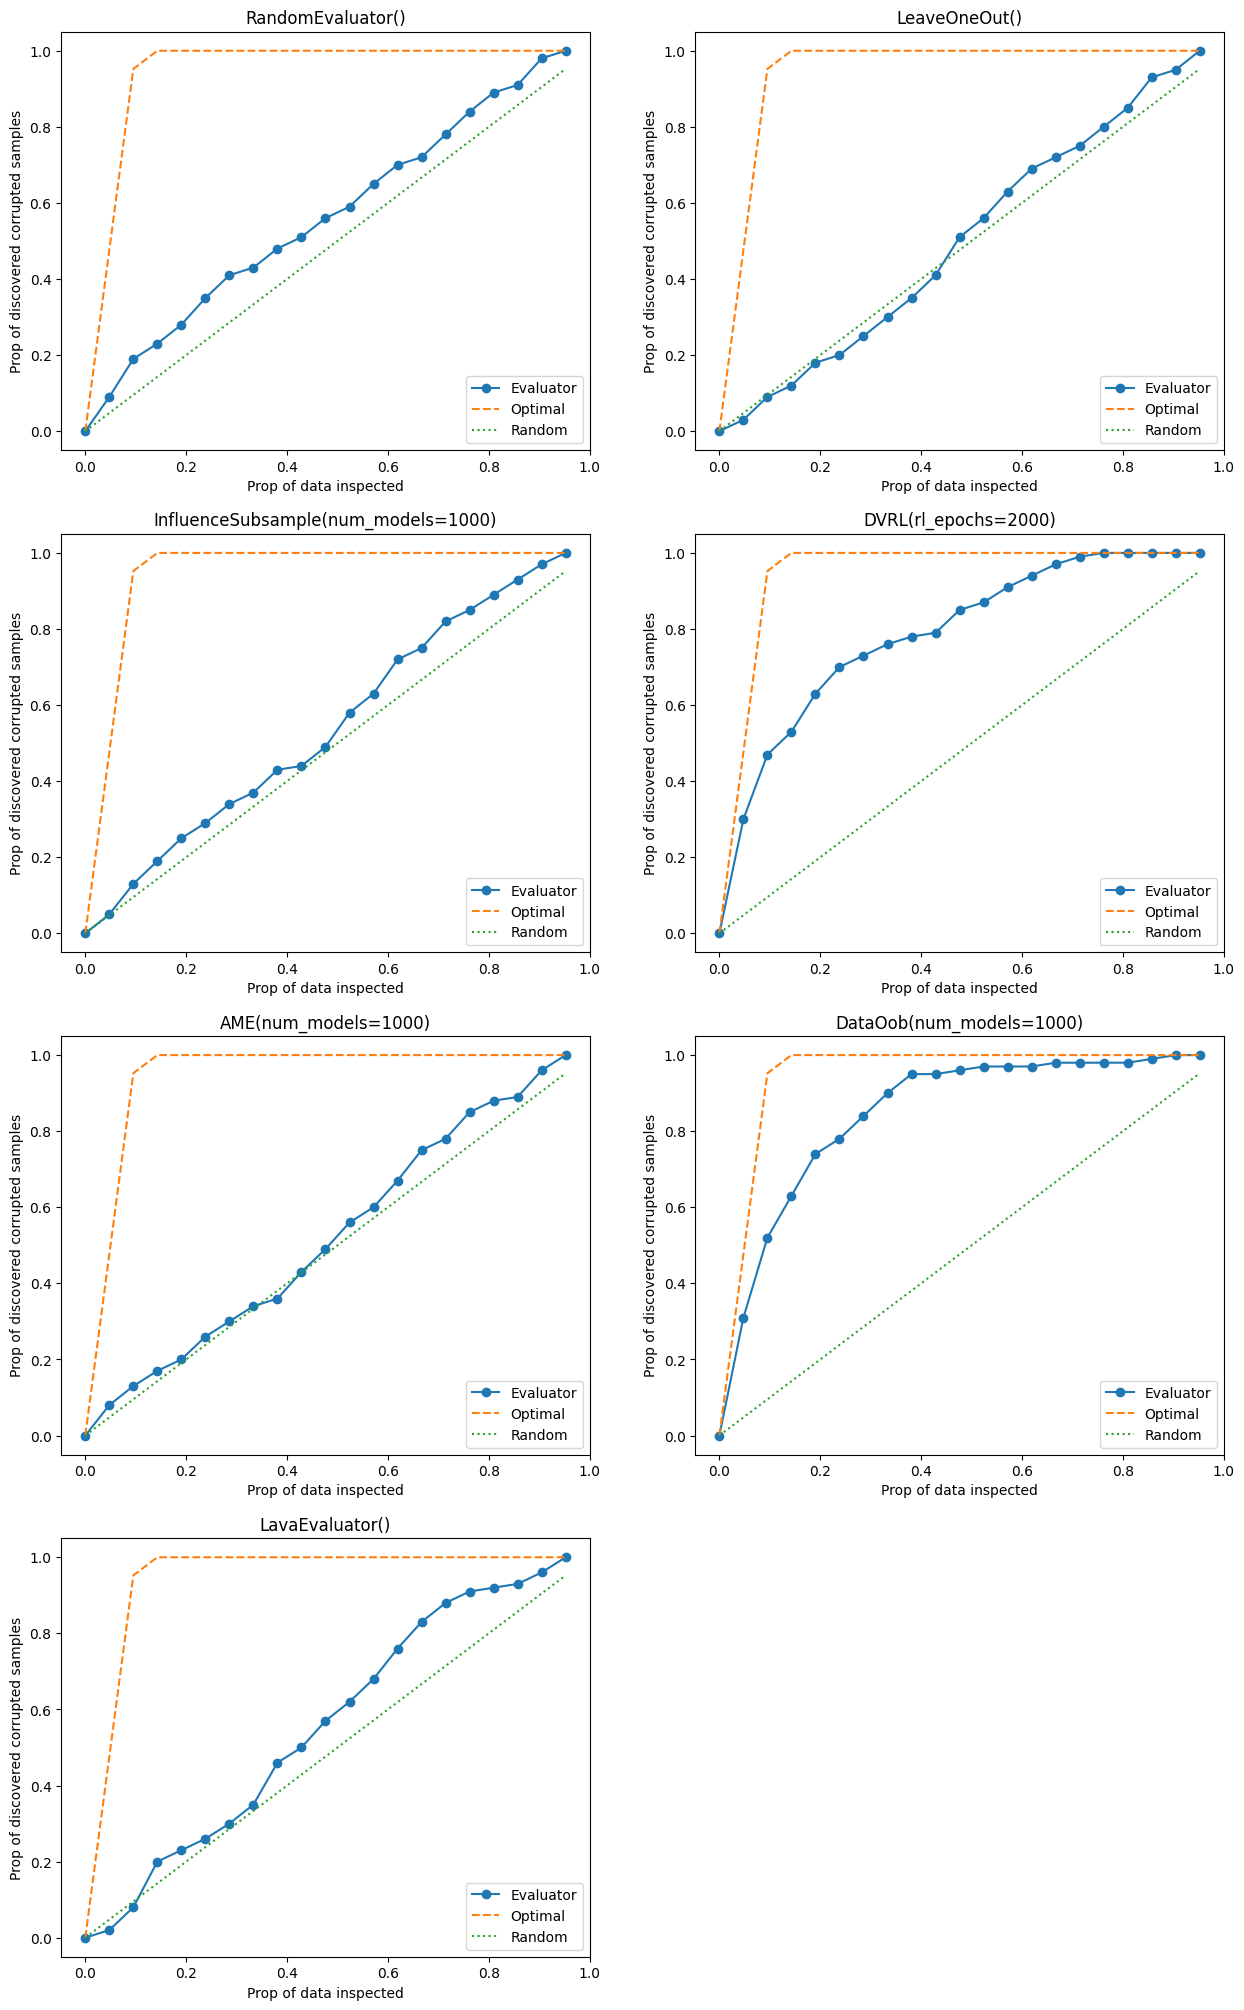

In [7]:
fig = plt.figure(figsize=(15, 25))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

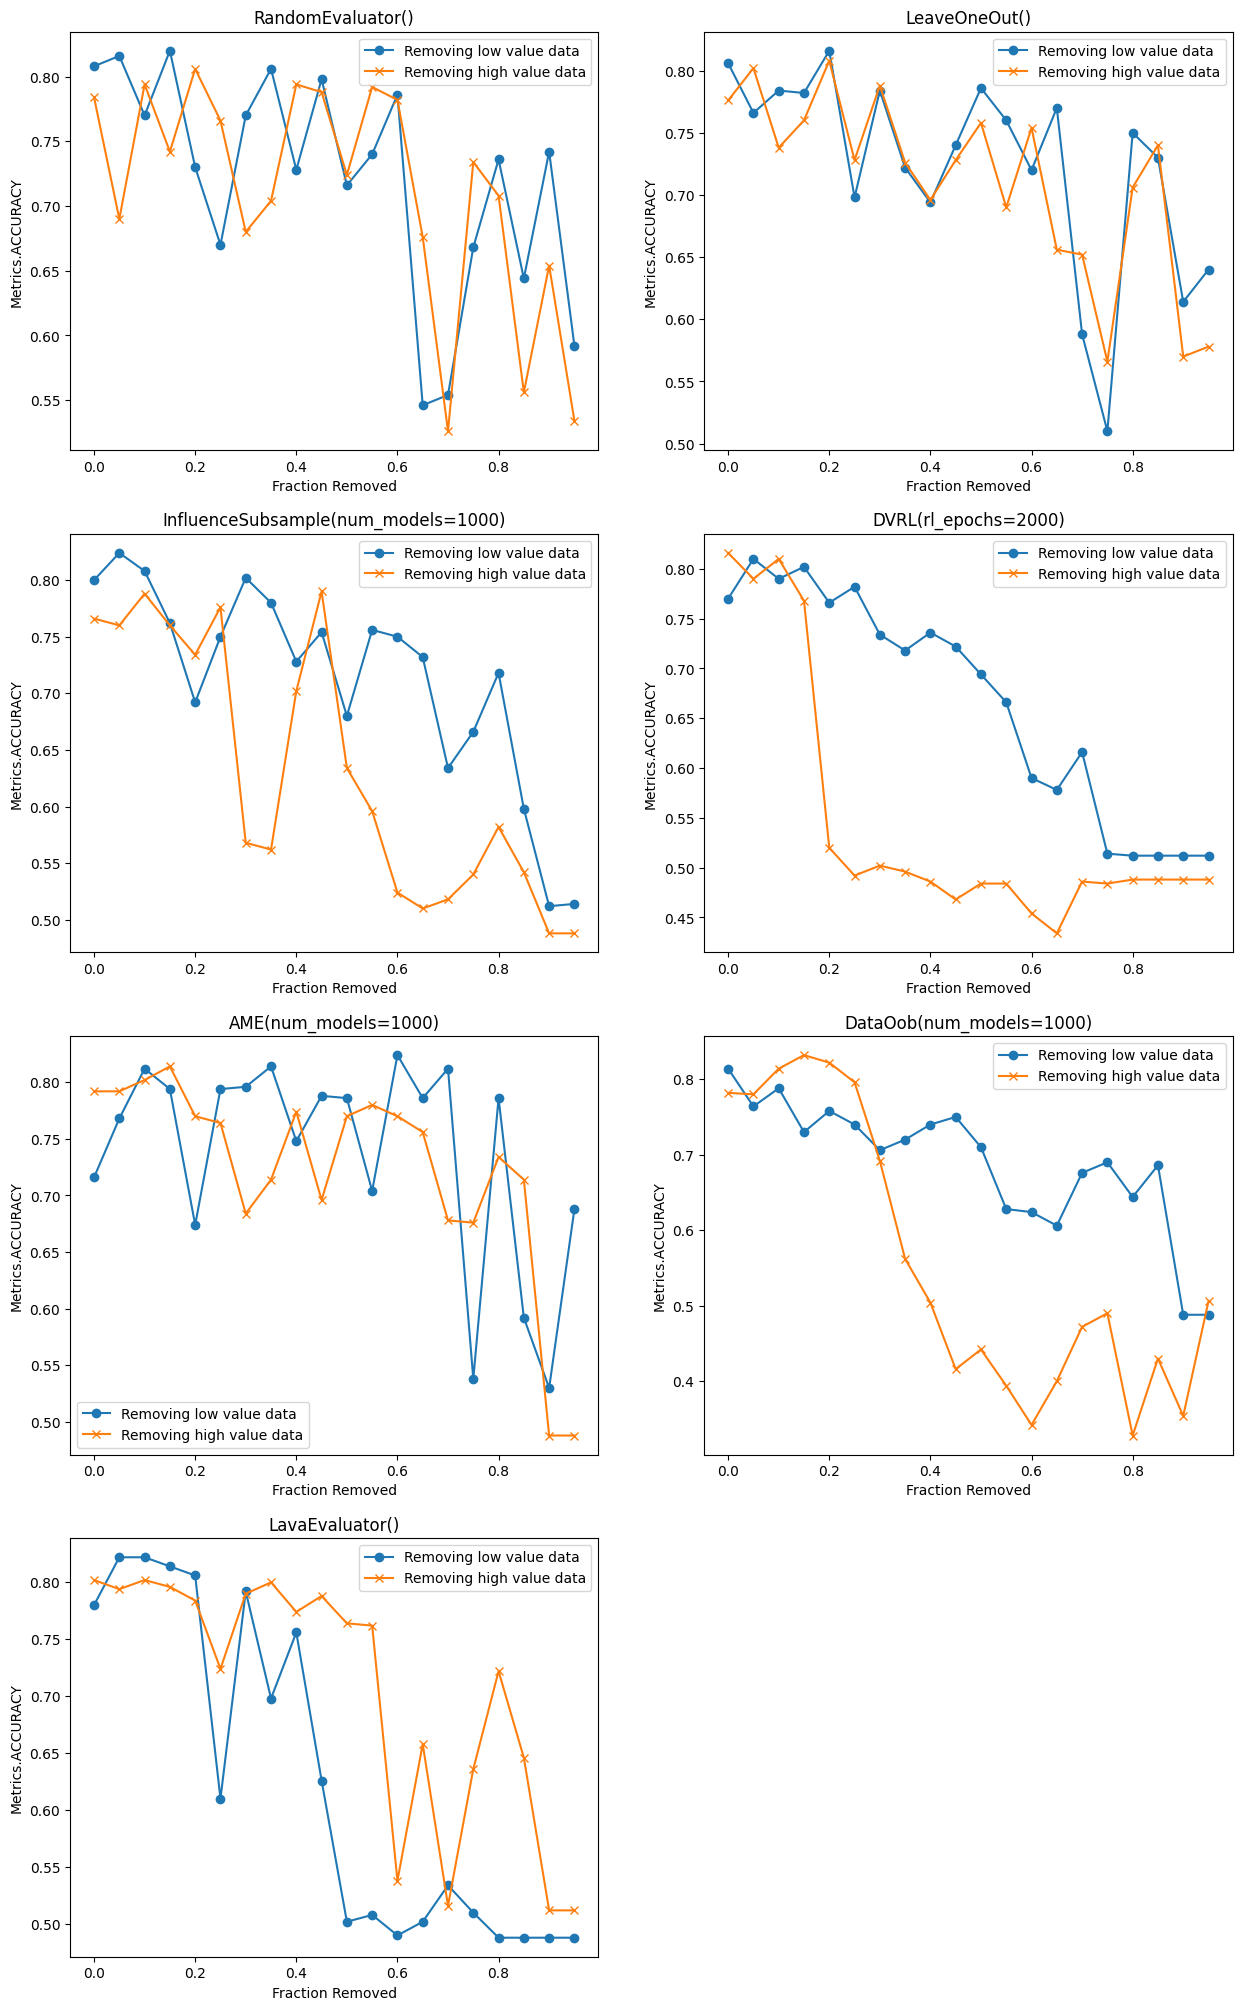

In [8]:
fig = plt.figure(figsize=(15, 25))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.808,0.784,0.0
RandomEvaluator(),0.816,0.69,0.05
RandomEvaluator(),0.77,0.794,0.1
RandomEvaluator(),0.82,0.742,0.15
RandomEvaluator(),0.73,0.806,0.2
...,...,...,...
LavaEvaluator(),0.51,0.636,0.75
LavaEvaluator(),0.488,0.722,0.8
LavaEvaluator(),0.488,0.646,0.85
LavaEvaluator(),0.488,0.512,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),9030,0.276855
RandomEvaluator(),27616,0.307186
RandomEvaluator(),16112,0.488999
RandomEvaluator(),37195,0.000691
RandomEvaluator(),36914,0.050761
...,...,...
LavaEvaluator(),9021,0.993084
LavaEvaluator(),18673,0.704196
LavaEvaluator(),27233,0.514492
LavaEvaluator(),9384,0.373331
